# Book Recommendation System (Using KNN Algorithm)


## Minor Project


BACHELOR OF TECHNOLOGY\
Computer Science and Engineering\
2019-2023

## Team
1. Konark Lohat
2. Gautam Jain
3. Jaskamal Singh

Dataset - http://www2.informatik.uni-freiburg.de/~cziegler/BX/

# Importing necessary packages

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading dataset with their respective (and required) features 

In [37]:
# Books dataset
books = pd.read_csv('./data/BX-Books.csv', sep = ';', error_bad_lines = False, encoding = 'latin-1')
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

# Users dataset
users = pd.read_csv('./data/BX-Users.csv', sep = ';', error_bad_lines = False, encoding='latin-1')
users.columns = ['userID', 'Location', 'Age']

# Ratings dataset
ratings = pd.read_csv('./data/BX-Book-Ratings.csv', sep = ';', error_bad_lines = False, encoding='latin-1')
ratings.columns = ['userID', 'ISBN', 'bookRating']

C:\Users\konar\AppData\Local\Temp\ipykernel_38960\1153141283.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  books = pd.read_csv('./data/BX-Books.csv', sep = ';', error_bad_lines = False, encoding = 'latin-1')
b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping

In [38]:
# Books dataset
print("\033[1mBooks Dataset\033[0m")
print("Rows - ", books.shape[0])
print("Cols - ", books.shape[1])
print("Cols are - ", list(books.columns))

# Users dataset
print("\n\033[1mUsers Dataset\033[0m")
print("Rows - ", users.shape[0])
print("Cols - ", users.shape[1])
print("Cols are - ", list(users.columns))

# Ratings dataset
print("\n\033[1mRatings Dataset\033[0m")
print("Rows - ", ratings.shape[0])
print("Cols - ", ratings.shape[1])
print("Cols are - ", list(ratings.columns))

Books Dataset
Rows -  271360
Cols -  8
Cols are -  ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

Users Dataset
Rows -  278858
Cols -  3
Cols are -  ['userID', 'Location', 'Age']

Ratings Dataset
Rows -  1149780
Cols -  3
Cols are -  ['userID', 'ISBN', 'bookRating']


# Rating Distribution

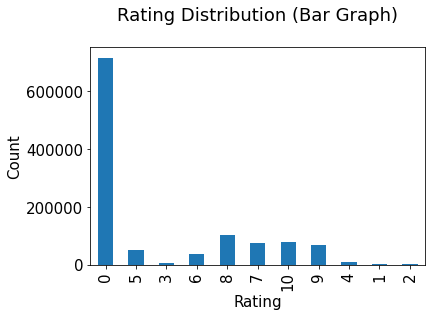

In [39]:
plt.rc('font', size = 15)
ratings.bookRating.value_counts(sort = False).plot(kind = 'bar')
plt.title("Rating Distribution (Bar Graph)\n")
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('./figures/rating-distribution.png', bbox_inches = 'tight')
plt.show()

# User's Age Distribution

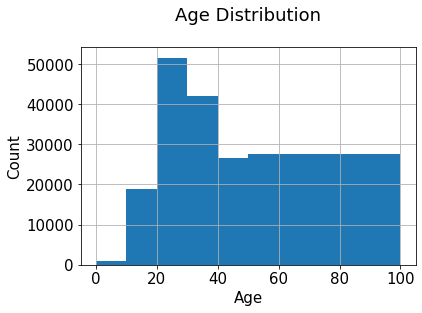

In [40]:
users.Age.hist(bins = [0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('./figures/user-age-distribution.png', bbox_inches = 'tight')
plt.show()

# To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings won't be used my the model.

In [41]:
# User's ratings
userRatingCount = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(userRatingCount[userRatingCount >= 200].index)]

# Book's ratings
bookRatingCount = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(bookRatingCount[bookRatingCount >= 100].index)]

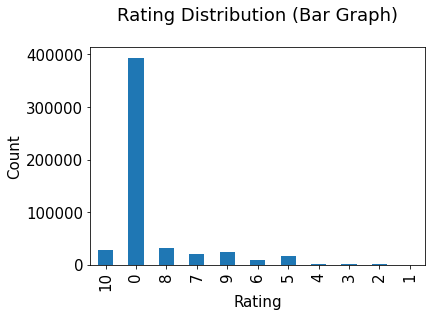

In [42]:
# TESTING THE EXCLUSION
plt.rc('font', size = 15)
ratings.bookRating.value_counts(sort = False).plot(kind = 'bar')
plt.title("Rating Distribution (Bar Graph)\n")
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('./figures/rating-distribution.png', bbox_inches = 'tight')
plt.show()